In [ ]:
!pip install scanpy
!pip install anndata
!pip install caas_jupyter_tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement caas_jupyter_tools (from versions: none)
ERROR: No matching distribution found for caas_jupyter_tools


In [ ]:
import anndata as ad
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
import networkx as nx
from collections import Counter
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree


import os, re, warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


In [ ]:
!wget https://datasets.cellxgene.cziscience.com/44bc6dd3-11c6-4efd-b995-fd75d330aea9.h5ad

--2025-09-29 16:24:44--  https://datasets.cellxgene.cziscience.com/44bc6dd3-11c6-4efd-b995-fd75d330aea9.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 13.32.87.43, 13.32.87.99, 13.32.87.40, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|13.32.87.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6323282648 (5.9G) [binary/octet-stream]
Saving to: ‘44bc6dd3-11c6-4efd-b995-fd75d330aea9.h5ad’

44bc6dd3-11c6-4efd- 100%[===================>]   5.89G   118MB/s    in 4m 1s   

2025-09-29 16:28:46 (25.0 MB/s) - ‘44bc6dd3-11c6-4efd-b995-fd75d330aea9.h5ad’ saved [6323282648/6323282648]



In [ ]:

# # File paths
input_folder = "/content/44bc6dd3-11c6-4efd-b995-fd75d330aea9.h5ad"
output_csv = "/content/combined_metadata.csv"


adata = ad.read_h5ad(input_folder)
df = adata.obs.copy()
df.to_csv("radc_cohort.csv", index = False)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/44bc6dd3-11c6-4efd-b995-fd75d330aea9.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
df.info()

NameError: name 'df' is not defined

In [ ]:
df.to_csv("radc_cohort.csv", index = False)

In [ ]:
df = pd.read_csv("df = pd.read_csv("/kaggle/working/Macular.csv")/kaggle/input/radc-cohortcsv/combined_metadata.csv")

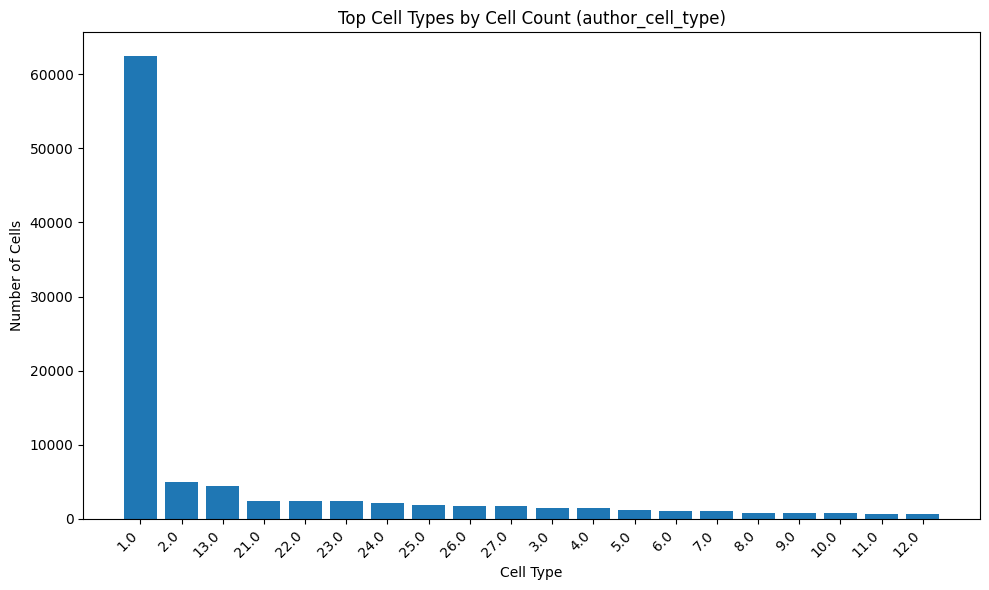

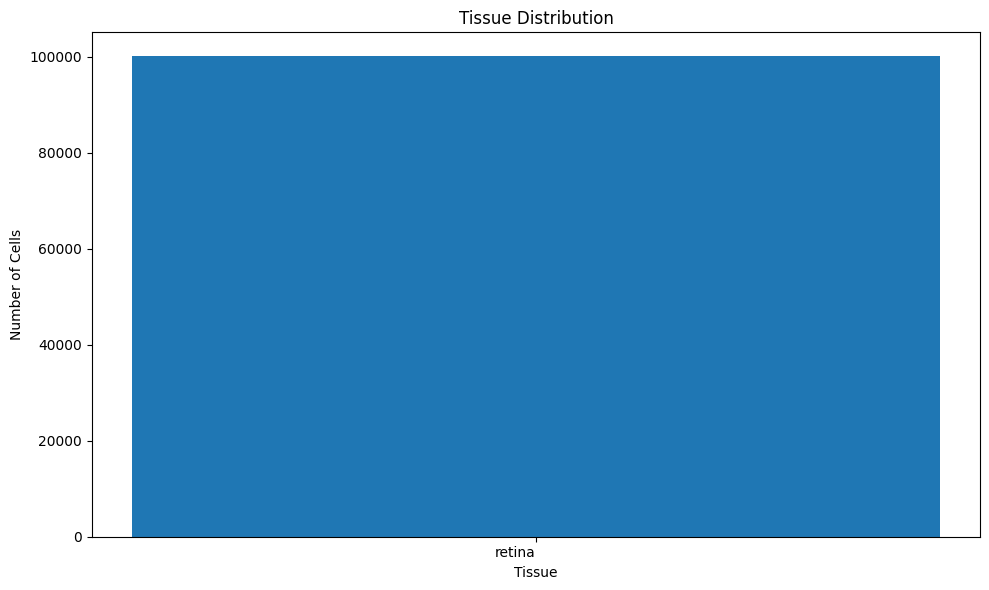

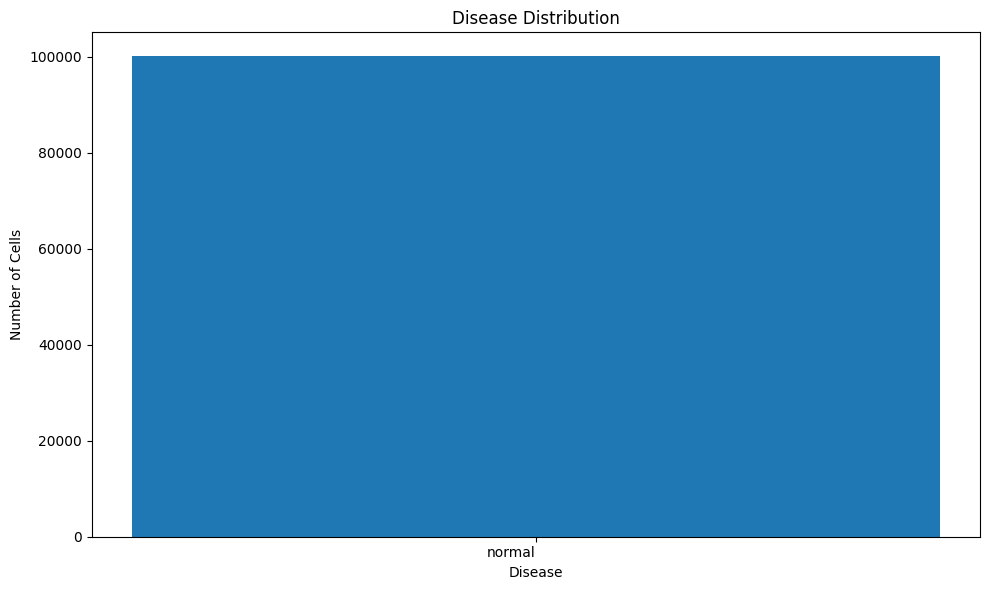

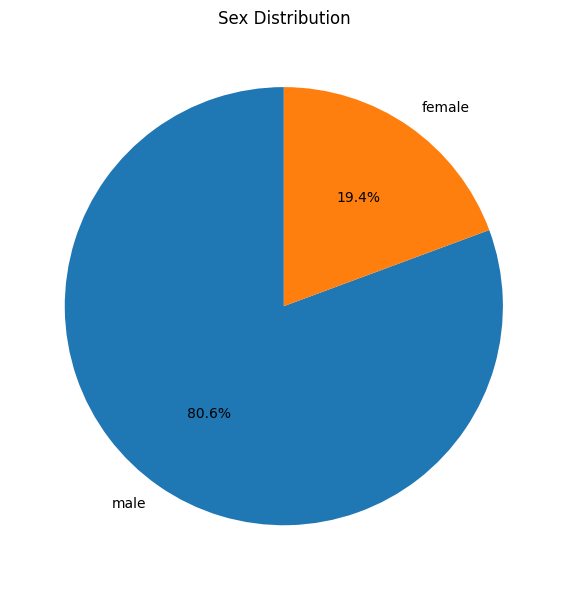

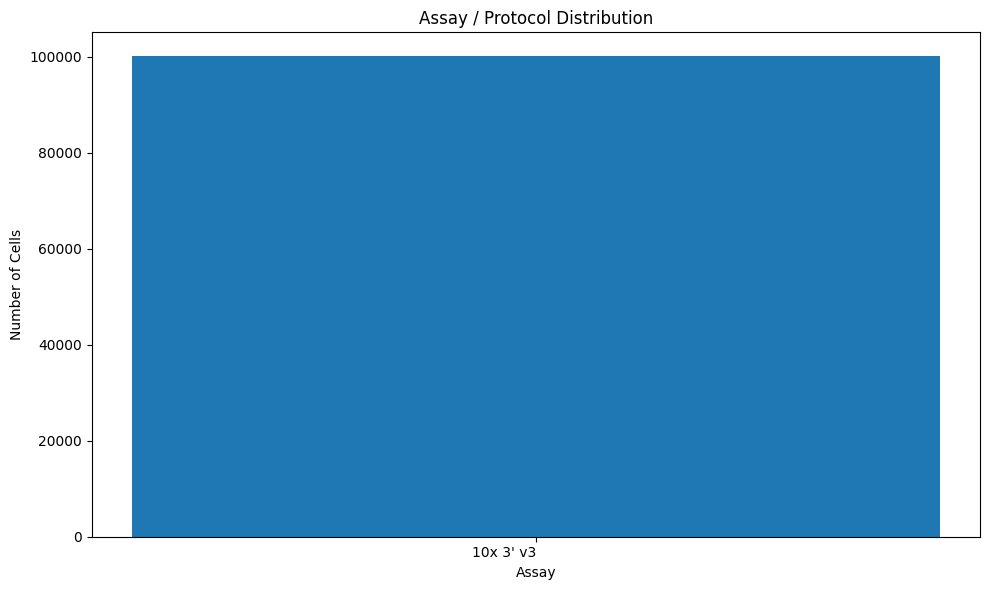

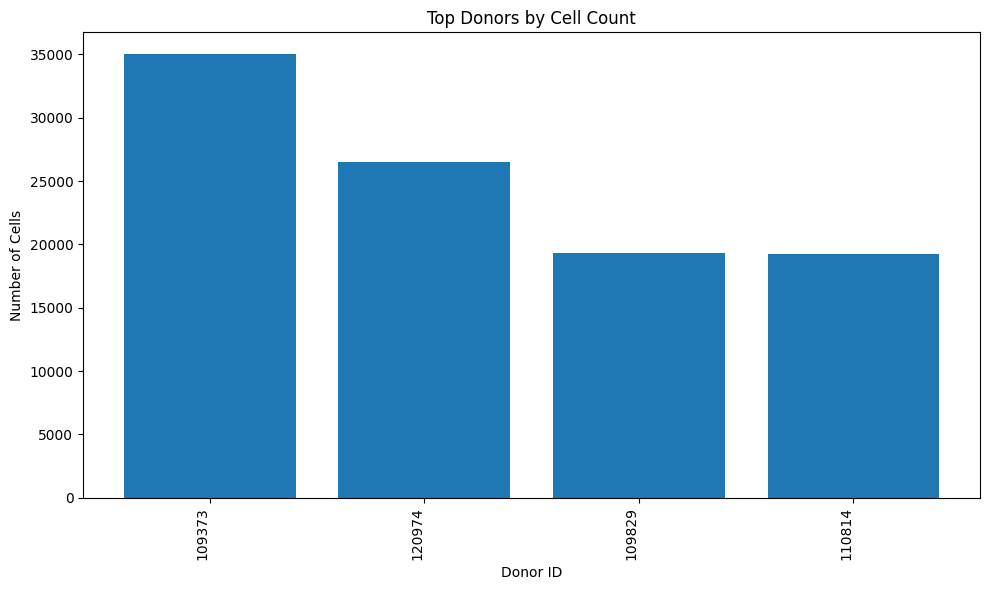

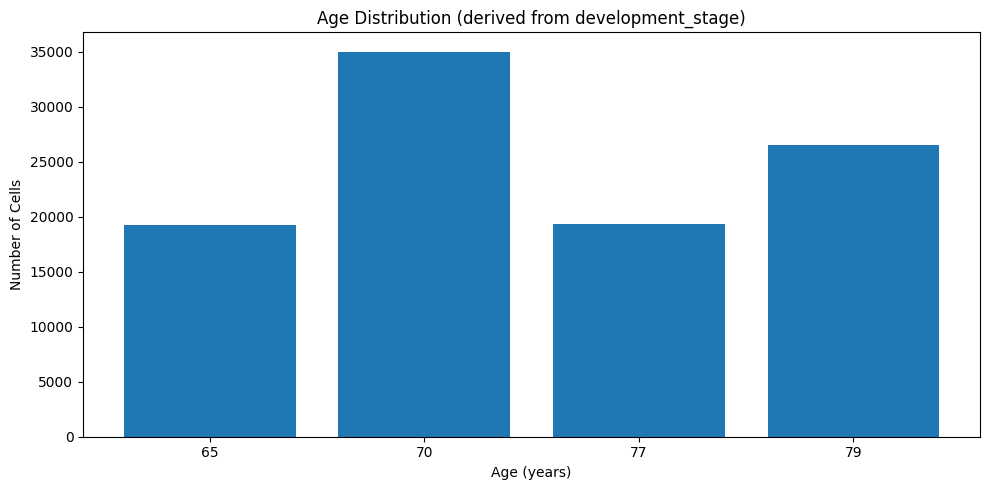

In [ ]:


colmap = {
    "cell_type": None,
    "author_cell_type": None,
    "tissue": None,
    "disease": None,
    "sex": None,
    "assay": None,
    "development_stage": None,
    "donor_id": None,
    "self_reported_ethnicity": None,
}

for c in list(colmap.keys()):
    if c in df.columns:
        colmap[c] = c


cell_col = colmap["author_cell_type"] or colmap["cell_type"]


if cell_col:
    ct_counts = df[cell_col].value_counts().reset_index()
    ct_counts.columns = ["cell_type", "n_cells"]
else:
    ct_counts = pd.DataFrame()


if colmap["tissue"]:
    tissue_counts = df[colmap["tissue"]].value_counts().reset_index()
    tissue_counts.columns = ["tissue", "n_cells"]
else:
    tissue_counts = pd.DataFrame()


if colmap["disease"]:
    disease_counts = df[colmap["disease"]].value_counts().reset_index()
    disease_counts.columns = ["disease", "n_cells"]
else:
    disease_counts = pd.DataFrame()


if colmap["sex"]:
    sex_counts = df[colmap["sex"]].value_counts().reset_index()
    sex_counts.columns = ["sex", "n_cells"]
else:
    sex_counts = pd.DataFrame()


if colmap["assay"]:
    assay_counts = df[colmap["assay"]].value_counts().reset_index()
    assay_counts.columns = ["assay", "n_cells"]
else:
    assay_counts = pd.DataFrame()


if colmap["donor_id"]:
    donor_counts = df[colmap["donor_id"]].value_counts().reset_index()
    donor_counts.columns = ["donor_id", "n_cells"]
else:
    donor_counts = pd.DataFrame()


def extract_age(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    for token in s.replace("-", " ").split():
        if token.isdigit():
            try:
                v = int(token)
                if 0 < v < 120:
                    return v
            except:
                pass
    return np.nan

if colmap["development_stage"]:
    ages = df[colmap["development_stage"]].map(extract_age)
    age_df = ages.dropna().astype(int).value_counts().sort_index().reset_index()
    age_df.columns = ["age_years", "n_cells"]
else:
    age_df = pd.DataFrame()


def plot_bar_from_counts(count_df, cat_col, count_col, title, xlabel, ylabel, max_bars=20, rotate=45):
    if count_df is None or count_df.empty:
        return
    top_df = count_df.head(max_bars)
    labels = [ "\n".join(wrap(str(x), 20)) for x in top_df[cat_col] ]
    x = np.arange(len(labels))
    y = top_df[count_col].values

    plt.figure(figsize=(10, 6))
    plt.bar(x, y)
    plt.xticks(x, labels, rotation=rotate, ha='right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


if not ct_counts.empty:
    plot_bar_from_counts(ct_counts, "cell_type", "n_cells",
                         f"Top Cell Types by Cell Count ({cell_col})",
                         "Cell Type", "Number of Cells", max_bars=20, rotate=45)

if not tissue_counts.empty:
    plot_bar_from_counts(tissue_counts, "tissue", "n_cells",
                         "Tissue Distribution", "Tissue", "Number of Cells", max_bars=20, rotate=0)


if not disease_counts.empty:
    plot_bar_from_counts(disease_counts, "disease", "n_cells",
                         "Disease Distribution", "Disease", "Number of Cells", max_bars=20, rotate=0)


if not sex_counts.empty:
    plt.figure(figsize=(6, 6))
    plt.pie(sex_counts["n_cells"], labels=sex_counts["sex"], autopct="%1.1f%%", startangle=90)
    plt.title("Sex Distribution")
    plt.tight_layout()
    plt.show()


if not assay_counts.empty:
    plot_bar_from_counts(assay_counts, "assay", "n_cells",
                         "Assay / Protocol Distribution", "Assay", "Number of Cells", max_bars=15, rotate=0)


if not donor_counts.empty:
    plot_bar_from_counts(donor_counts, "donor_id", "n_cells",
                         "Top Donors by Cell Count", "Donor ID", "Number of Cells", max_bars=20, rotate=90)


if not age_df.empty:
    plt.figure(figsize=(10, 5))
    plt.bar(age_df["age_years"].astype(str), age_df["n_cells"])
    plt.title("Age Distribution (derived from development_stage)")
    plt.xlabel("Age (years)")
    plt.ylabel("Number of Cells")
    plt.tight_layout()
    plt.show()


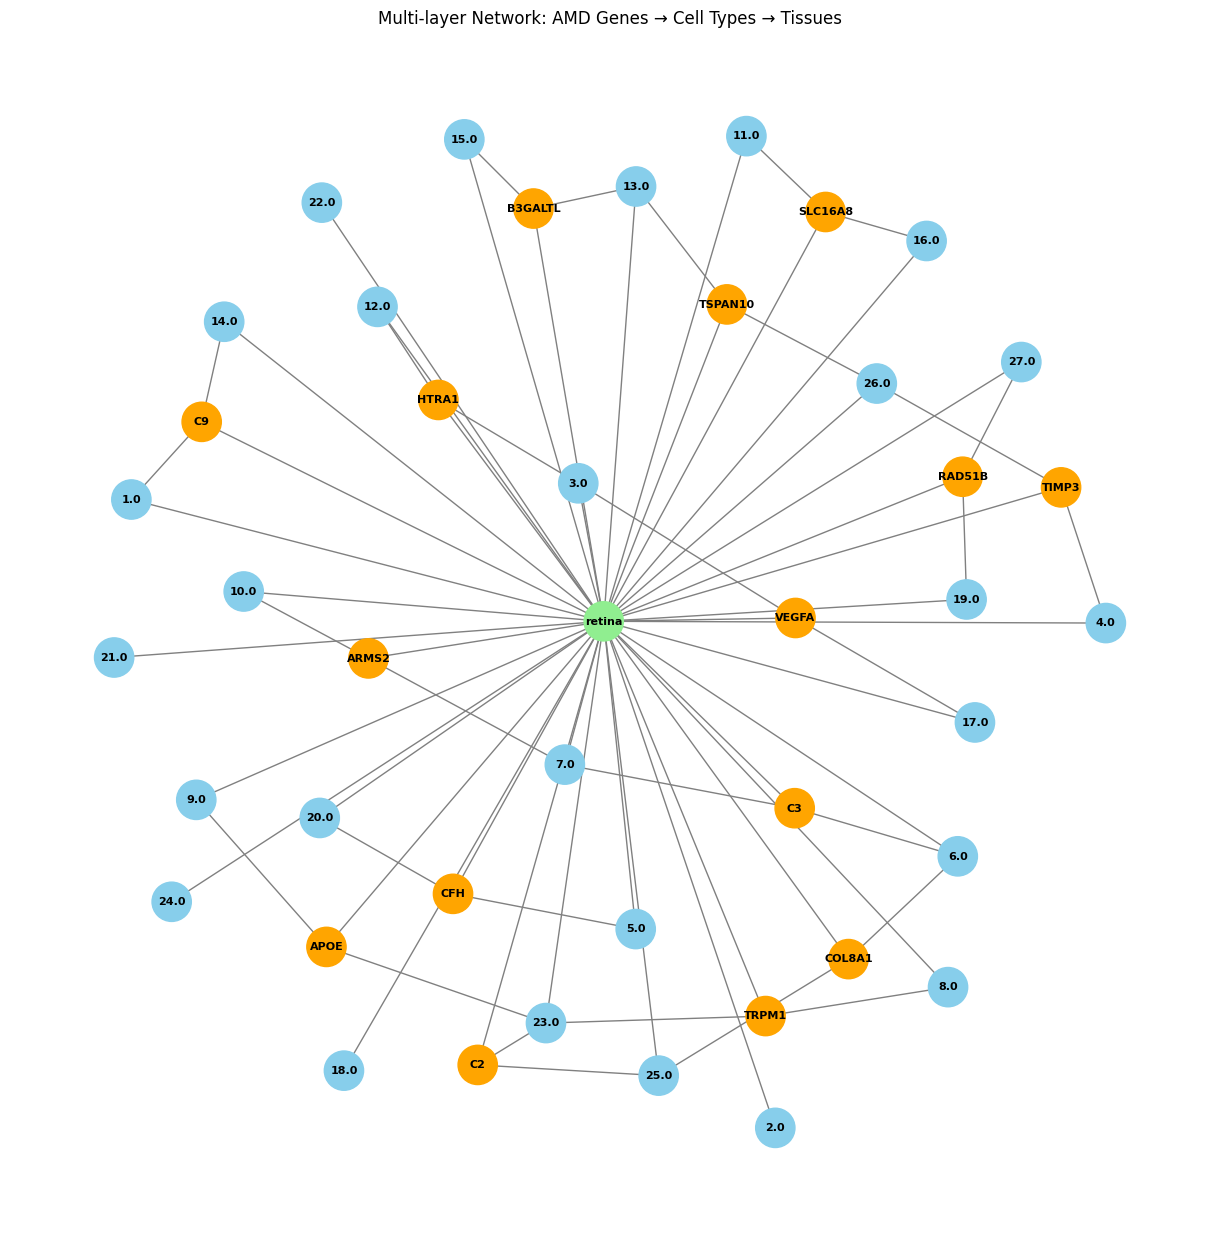

In [ ]:
cell_col = "author_cell_type" if "author_cell_type" in df.columns else "cell_type"
tissue_col = "tissue" if "tissue" in df.columns else None
amd_genes = ["CFH", "C3", "C2", "ARMS2", "HTRA1", "TSPAN10", "TRPM1",
             "C9", "APOE", "TIMP3", "VEGFA", "COL8A1", "RAD51B", "B3GALTL", "SLC16A8"]

G = nx.Graph()
G.add_nodes_from(amd_genes, bipartite="gene")

if cell_col in df.columns:
    cell_types = df[cell_col].dropna().unique().tolist()
    G.add_nodes_from(cell_types, bipartite="cell")
else:
    cell_types = []

if tissue_col in df.columns:
    tissues = df[tissue_col].dropna().unique().tolist()
    G.add_nodes_from(tissues, bipartite="tissue")
else:
    tissues = []

import random
random.seed(42)

for g in amd_genes:
    for ct in random.sample(cell_types, min(2, len(cell_types))):
        G.add_edge(g, ct)
    if tissues:
        t = random.choice(tissues)
        G.add_edge(g, t)


if cell_types and tissues:
    ct_tissue_counts = df.groupby([cell_col, tissue_col]).size().reset_index(name="count")
    for _, row in ct_tissue_counts.iterrows():
        G.add_edge(row[cell_col], row[tissue_col])


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)


node_colors = []
for n in G.nodes():
    if n in amd_genes:
        node_colors.append("orange")
    elif n in cell_types:
        node_colors.append("skyblue")
    else:
        node_colors.append("lightgreen")

nx.draw(G, pos, with_labels=True, node_size=800, node_color=node_colors,
        font_size=8, font_weight="bold", edge_color="gray")
plt.title("Multi-layer Network: AMD Genes → Cell Types → Tissues")
plt.show()

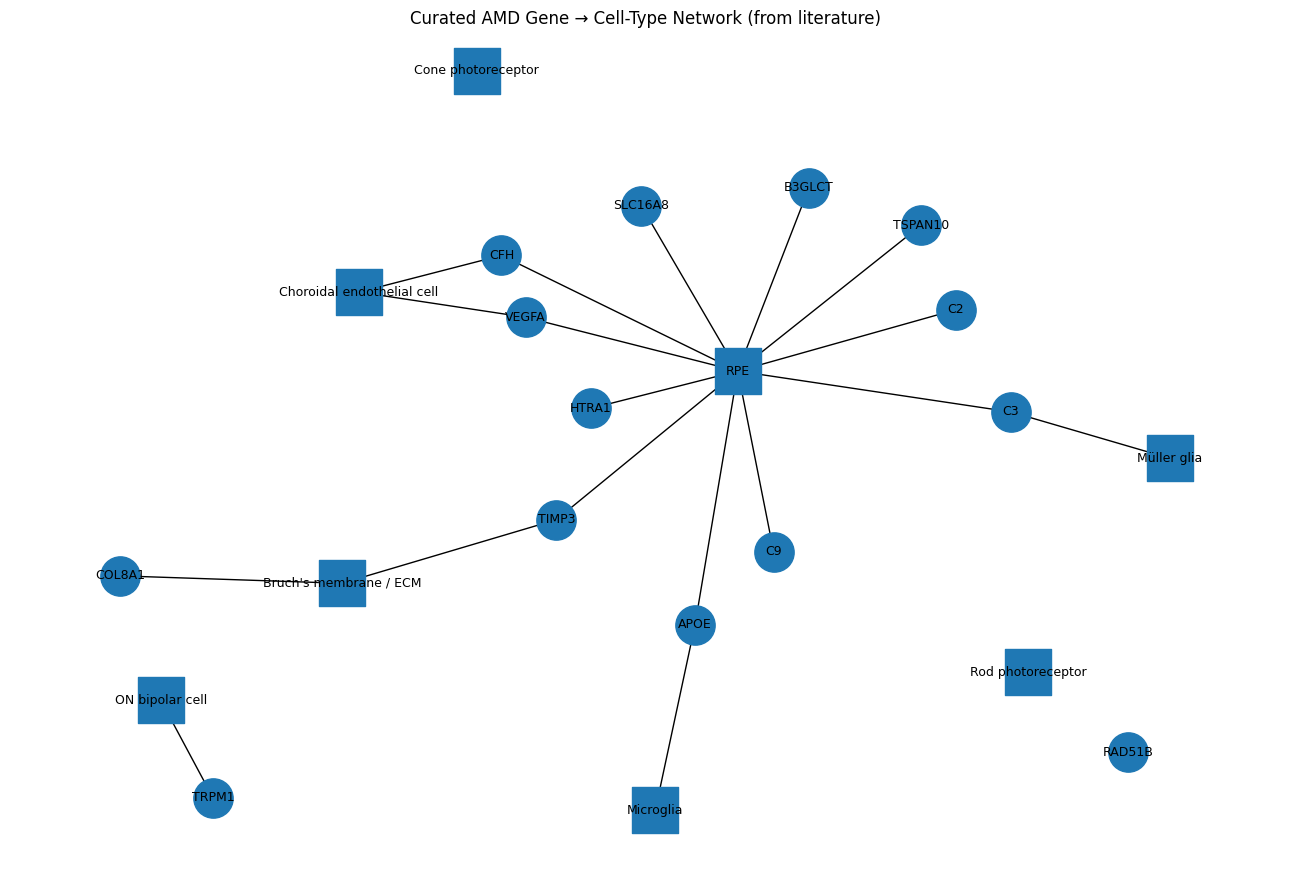

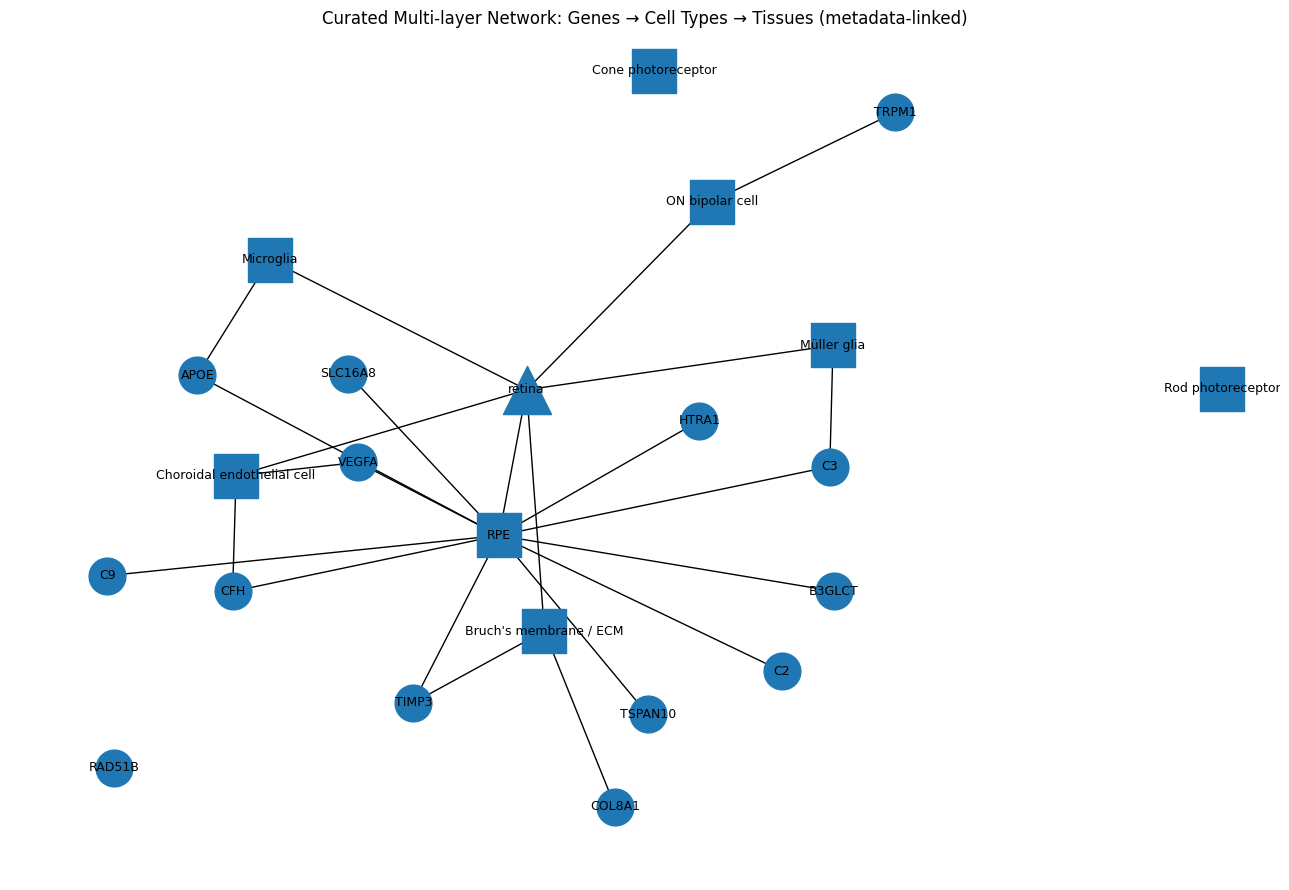

In [ ]:


cell_nodes = [
    "RPE",
    "ON bipolar cell",
    "Rod photoreceptor",
    "Cone photoreceptor",
    "Müller glia",
    "Microglia",
    "Choroidal endothelial cell",
    "Bruch's membrane / ECM",
]


genes = [
    "CFH","C3","C2","C9",
    "HTRA1","TSPAN10","TRPM1","SLC16A8",
    "APOE","TIMP3","VEGFA","COL8A1",
    "RAD51B","B3GLCT"
]


gene_to_cells = {
    "CFH": ["RPE", "Choroidal endothelial cell"],
    "C3":  ["RPE", "Müller glia"],
    "C2":  ["RPE"],
    "C9":  ["RPE"],
    # 10q26 locus & RPE genes
    "HTRA1": ["RPE"],
    "TSPAN10": ["RPE"],
    # RPE transporters
    "SLC16A8": ["RPE"],
    # Neuronal channels
    "TRPM1": ["ON bipolar cell"],
    # Lipid/immune
    "APOE": ["RPE", "Microglia"],
    # ECM & angiogenic pathway
    "TIMP3": ["RPE","Bruch's membrane / ECM"],
    "VEGFA": ["RPE","Choroidal endothelial cell"],
    "COL8A1": ["Bruch's membrane / ECM"],
    "RAD51B": [],
    "B3GLCT": ["RPE"],
}


G = nx.Graph()
G.add_nodes_from(genes, bipartite="gene")
G.add_nodes_from(cell_nodes, bipartite="cell")

# Add edges gene→cell-type
for g, cells in gene_to_cells.items():
    for c in cells:
        if c in cell_nodes:
            G.add_edge(g, c)

# Draw
plt.figure(figsize=(13, 9))
pos = nx.spring_layout(G, seed=7, k=0.6)
nx.draw_networkx_nodes(G, pos, nodelist=genes, node_size=800)
nx.draw_networkx_nodes(G, pos, nodelist=cell_nodes, node_shape="s", node_size=1100)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("Curated AMD Gene → Cell-Type Network (from literature)")
plt.axis("off")
plt.tight_layout()
plt.show()

import os, json
try:
    mac_df = pd.read_csv("/kaggle/working/Macular.csv")
    tissues = mac_df["tissue"].dropna().unique().tolist() if "tissue" in mac_df.columns else []
except Exception as e:
    tissues = []

if tissues:
    G2 = nx.Graph()
    G2.add_nodes_from(genes, bipartite="gene")
    G2.add_nodes_from(cell_nodes, bipartite="cell")
    G2.add_nodes_from(tissues, bipartite="tissue")

    for g, cells in gene_to_cells.items():
        for c in cells:
            if c in cell_nodes:
                G2.add_edge(g, c)
                for t in tissues:
                    G2.add_edge(c, t)

    plt.figure(figsize=(13, 9))
    pos2 = nx.spring_layout(G2, seed=11, k=0.7)
    nx.draw_networkx_nodes(G2, pos2, nodelist=genes, node_size=700)
    nx.draw_networkx_nodes(G2, pos2, nodelist=cell_nodes, node_shape="s", node_size=1000)
    nx.draw_networkx_nodes(G2, pos2, nodelist=tissues, node_shape="^", node_size=1200)
    nx.draw_networkx_edges(G2, pos2)
    nx.draw_networkx_labels(G2, pos2, font_size=9)
    plt.title("Curated Multi-layer Network: Genes → Cell Types → Tissues (metadata-linked)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:




INPUT_CSV = "/kaggle/working/Macular.csv"
OUT_DIR   = Path("/kaggle/working/")
OUT_DIR.mkdir(parents=True, exist_ok=True)

CELL_NODES_CURATED = [
    "RPE",
    "ON bipolar cell",
    "Rod photoreceptor",
    "Cone photoreceptor",
    "Müller glia",
    "Microglia",
    "Choroidal endothelial cell",
    "Bruch's membrane / ECM",
]

GENES = [
    "CFH","C3","C2","C9",
    "HTRA1","TSPAN10","TRPM1","SLC16A8",
    "APOE","TIMP3","VEGFA","COL8A1",
    "RAD51B","B3GLCT"
]


EVIDENCE = {
    "functional_study":     {"weight": 1.0, "edge_color": "red"},
    "eqtl_colocalization":  {"weight": 0.9, "edge_color": "orange"},
    "celltype_expression":  {"weight": 0.8, "edge_color": "blue"},
    "review_level":         {"weight": 0.6, "edge_color": "gray"},
    "metadata_link":        {"weight": 0.0, "edge_color": "green"},
}


CURATED_LINKS = [
    {"gene": "CFH",   "cell": "RPE",                         "evidence": "celltype_expression", "note": "CFH expressed by RPE; AMD risk"},
    {"gene": "CFH",   "cell": "Choroidal endothelial cell",  "evidence": "review_level",        "note": "Endothelial complement regulation"},
    {"gene": "C3",    "cell": "RPE",                         "evidence": "celltype_expression", "note": "Local complement production"},
    {"gene": "C3",    "cell": "Müller glia",                 "evidence": "review_level",        "note": "Reported glial expression"},
    {"gene": "C2",    "cell": "RPE",                         "evidence": "review_level",        "note": "Complement pathway"},
    {"gene": "C9",    "cell": "RPE",                         "evidence": "review_level",        "note": "MAC component; deposits in AMD"},

    {"gene": "HTRA1", "cell": "RPE",                         "evidence": "functional_study",    "note": "10q26 locus; RPE functional effects"},
    {"gene": "TSPAN10","cell": "RPE",                        "evidence": "eqtl_colocalization", "note": "AMD eQTL; RPE enriched"},
    {"gene": "SLC16A8","cell": "RPE",                        "evidence": "functional_study",    "note": "RPE MCT3 transporter; causal evidence"},

    {"gene": "TRPM1", "cell": "ON bipolar cell",             "evidence": "functional_study",    "note": "ON-BC transduction channel"},

    {"gene": "APOE",  "cell": "RPE",                         "evidence": "review_level",        "note": "Lipid handling in RPE"},
    {"gene": "APOE",  "cell": "Microglia",                   "evidence": "review_level",        "note": "Immunomodulatory roles"},

    {"gene": "TIMP3", "cell": "RPE",                         "evidence": "functional_study",    "note": "Sorsby dystrophy; BrM accumulation"},
    {"gene": "TIMP3", "cell": "Bruch's membrane / ECM",      "evidence": "review_level",        "note": "ECM deposition"},
    {"gene": "VEGFA", "cell": "RPE",                         "evidence": "functional_study",    "note": "RPE-derived VEGF supports choriocapillaris"},
    {"gene": "VEGFA", "cell": "Choroidal endothelial cell",  "evidence": "review_level",        "note": "Endothelial target of VEGF"},
    {"gene": "COL8A1","cell": "Bruch's membrane / ECM",      "evidence": "review_level",        "note": "BrM component; AMD-associated"},
    {"gene": "B3GLCT","cell": "RPE",                         "evidence": "review_level",        "note": "aka B3GALTL"},

]


def build_gene_cell_graph(cur_links, evidence_map):
    """Gene↔Cell network with evidence-weighted edges."""
    G = nx.Graph()
    for g in GENES:
        G.add_node(g, node_type="gene")
    for c in CELL_NODES_CURATED:
        G.add_node(c, node_type="cell")
    for rec in cur_links:
        ev = evidence_map[rec["evidence"]]
        G.add_edge(
            rec["gene"], rec["cell"],
            evidence_type=rec["evidence"],
            weight=float(ev["weight"]),
            edge_color=ev["edge_color"],
            note=rec.get("note", "")
        )
    return G

def build_multilayer_graph(G_base, df, tissue_col: str | None):
    """Add tissues from metadata and connect cell→tissue with weights = counts per tissue."""
    G = G_base.copy()
    tissues = []
    if tissue_col and tissue_col in df.columns:
        tissues = sorted(t for t in df[tissue_col].dropna().unique().tolist())
        for t in tissues:
            G.add_node(t, node_type="tissue")
        # count cells per tissue (metadata-driven weight)
        tissue_counts = Counter(df[tissue_col].dropna().tolist())
        for cell_node in CELL_NODES_CURATED:
            for t in tissues:
                G.add_edge(
                    cell_node, t,
                    evidence_type="metadata_link",
                    weight=float(tissue_counts.get(t, 0)),
                    edge_color=EVIDENCE["metadata_link"]["edge_color"],
                    note="Linked via dataset tissue; weight=#cells in tissue"
                )
    return G

def graph_to_tables(G: nx.Graph):
    nodes, edges = [], []
    for n, attrs in G.nodes(data=True):
        row = {"id": n}
        row.update(attrs)
        nodes.append(row)
    for u, v, attrs in G.edges(data=True):
        row = {"source": u, "target": v}
        row.update(attrs)
        edges.append(row)
    return pd.DataFrame(nodes), pd.DataFrame(edges)


df = pd.read_csv(INPUT_CSV)
tissue_col = "tissue" if "tissue" in df.columns else None


G_gene_cell  = build_gene_cell_graph(CURATED_LINKS, EVIDENCE)
G_multilayer = build_multilayer_graph(G_gene_cell, df, tissue_col)


gene_cell_graphml   = OUT_DIR / "LUMINA_gene_cell_evidence.graphml"
multilayer_graphml  = OUT_DIR / "LUMINA_multilayer_gene_cell_tissue.graphml"
nx.write_graphml(G_gene_cell, gene_cell_graphml.as_posix())
nx.write_graphml(G_multilayer, multilayer_graphml.as_posix())

nodes_gc, edges_gc = graph_to_tables(G_gene_cell)
nodes_ml, edges_ml = graph_to_tables(G_multilayer)
nodes_gc.to_csv(OUT_DIR / "LUMINA_gene_cell_nodes.csv", index=False)
edges_gc.to_csv(OUT_DIR / "LUMINA_gene_cell_edges.csv", index=False)
nodes_ml.to_csv(OUT_DIR / "LUMINA_multilayer_nodes.csv", index=False)
edges_ml.to_csv(OUT_DIR / "LUMINA_multilayer_edges.csv", index=False)

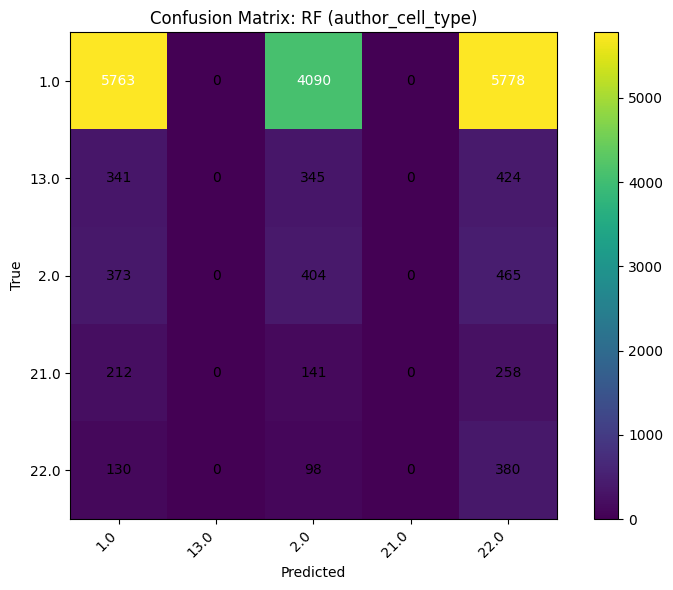

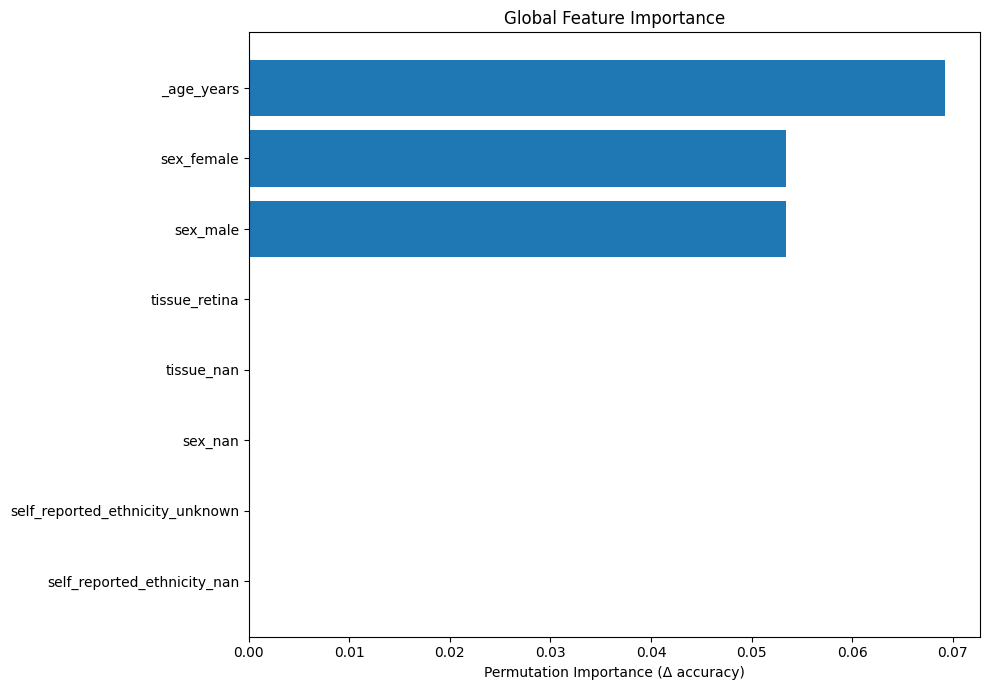

PDP/ICE skipped: target must be specified for multi-class


<Figure size 800x600 with 0 Axes>

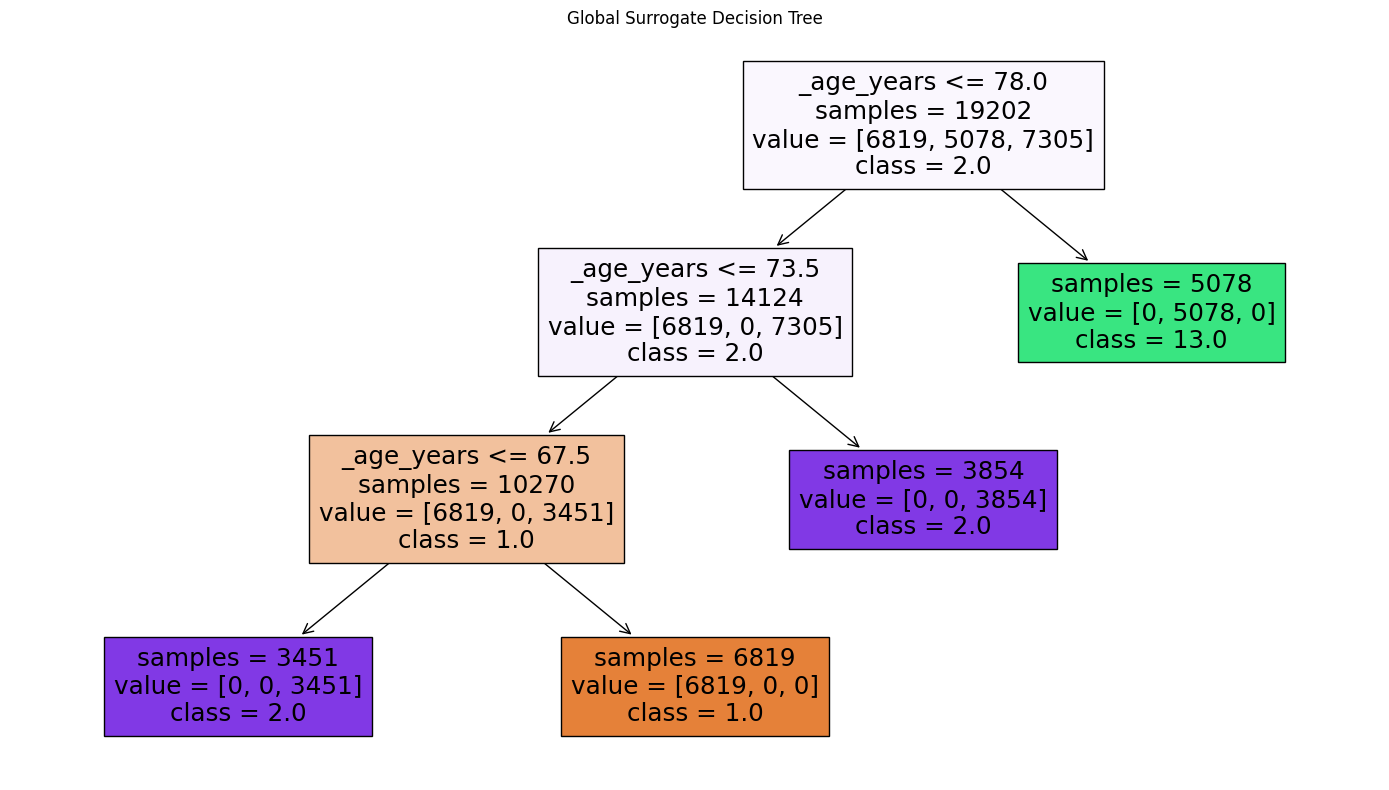

              precision    recall  f1-score   support

         1.0       0.85      0.37      0.51     15631
        13.0       0.00      0.00      0.00      1110
         2.0       0.08      0.33      0.13      1242
        21.0       0.00      0.00      0.00       611
        22.0       0.05      0.62      0.10       608

    accuracy                           0.34     19202
   macro avg       0.20      0.26      0.15     19202
weighted avg       0.69      0.34      0.43     19202



In [ ]:

def extract_age(x):
    if pd.isna(x): return np.nan
    for tok in str(x).replace("-", " ").split():
        if tok.isdigit():
            v = int(tok)
            if 0 < v < 120: return v
    return np.nan

if "development_stage" in df.columns:
    df["_age_years"] = df["development_stage"].map(extract_age)

cell_col = "author_cell_type" if "author_cell_type" in df.columns else ("cell_type" if "cell_type" in df.columns else None)
target_col = None
if "disease" in df.columns and df["disease"].dropna().nunique() >= 2:
    target_col = "disease"
elif cell_col is not None:
    top5 = df[cell_col].value_counts().head(5).index.tolist()
    df = df[df[cell_col].isin(top5)].copy()
    target_col = cell_col
else:
    raise ValueError("Need 'disease' or 'cell_type' as target.")

feat_cols = [c for c in ["tissue","sex","self_reported_ethnicity"] if c in df.columns]
if "_age_years" in df.columns: feat_cols.append("_age_years")
if not feat_cols: raise ValueError("No usable feature columns found.")

X = df[feat_cols].copy()
y = df[target_col].astype(str)
X = pd.get_dummies(X, columns=[c for c in feat_cols if X[c].dtype=='object'], dummy_na=True)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1).fit(Xtr, ytr)


labels = sorted(y.unique().tolist())
cm = confusion_matrix(yte, rf.predict(Xte), labels=labels)
plt.figure(figsize=(8,6)); plt.imshow(cm); plt.title(f"Confusion Matrix: RF ({target_col})"); plt.colorbar()
ticks = np.arange(len(labels)); plt.xticks(ticks, labels, rotation=45, ha='right'); plt.yticks(ticks, labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center", color="white" if cm[i,j] > cm.max()/2 else "black")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()


perm = permutation_importance(rf, Xte, yte, n_repeats=10, random_state=42, n_jobs=-1)
imp = (pd.DataFrame({"feature": Xte.columns, "importance": perm.importances_mean})
       .sort_values("importance", ascending=False).head(20))
plt.figure(figsize=(10,7)); yidx=np.arange(len(imp))
plt.barh(yidx, imp["importance"]); plt.yticks(yidx, imp["feature"]); plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (Δ accuracy)"); plt.title("Global Feature Importance"); plt.tight_layout(); plt.show()


if "_age_years" in Xte.columns:
    try:
        plt.figure(figsize=(8,6))
        PartialDependenceDisplay.from_estimator(rf, Xte, ["_age_years"], kind="both", subsample=100, random_state=42)
        plt.title("PDP & ICE: Age → Predicted Probability"); plt.tight_layout(); plt.show()
    except Exception as e:
        print("PDP/ICE skipped:", e)


y_rf = rf.predict(Xte)
sur = DecisionTreeClassifier(max_depth=3, random_state=42).fit(Xte, y_rf)
plt.figure(figsize=(14,8)); plot_tree(sur, feature_names=Xte.columns.tolist(), class_names=labels, filled=True, impurity=False)
plt.title("Global Surrogate Decision Tree"); plt.tight_layout(); plt.show()

print(classification_report(yte, rf.predict(Xte)))



=== Cross-validated Performance (celltype) ===

             model  accuracy_mean  accuracy_std  f1_macro_mean  f1_macro_std  cv_folds  n_samples  n_classes notes
       BernoulliNB       0.946200  4.521553e-04       0.792562      0.002866         5      15000         10      
 PassiveAggressive       0.945133  2.227106e-03       0.790424      0.015381         5      15000         10      
     MultinomialNB       0.945800  8.589399e-04       0.790339      0.003234         5      15000         10      
         LinearSVC       0.948000  1.110223e-16       0.768875      0.000061         5      15000         10      
 SGDClassifier-log       0.948000  1.110223e-16       0.768875      0.000061         5      15000         10      
   RidgeClassifier       0.948000  1.110223e-16       0.768875      0.000061         5      15000         10      
      RandomForest       0.948000  1.110223e-16       0.768875      0.000061         5      15000         10      
      ComplementNB       0.9480

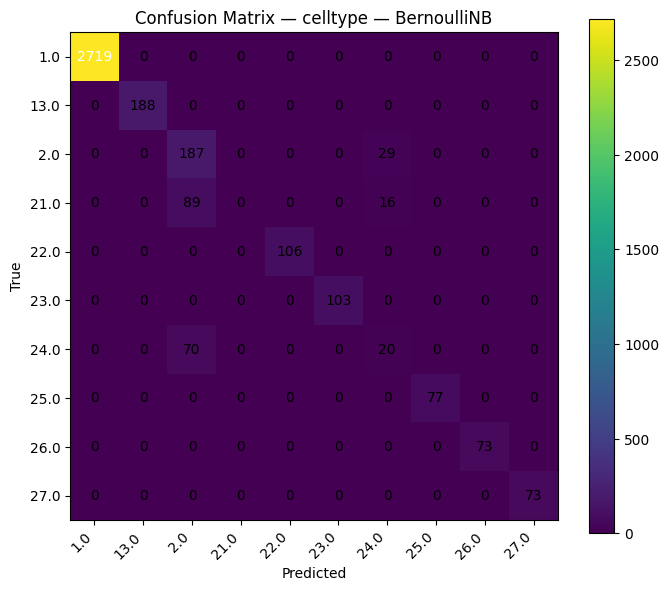

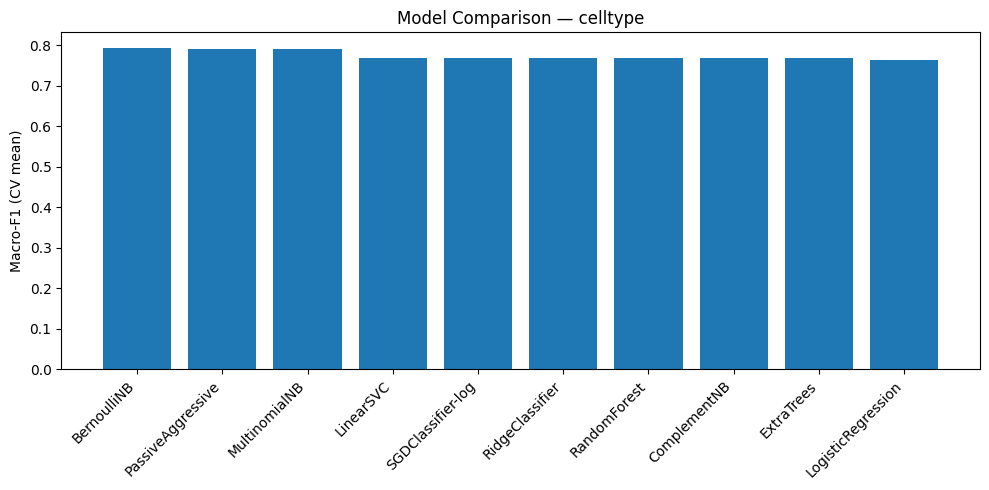

Disease column has <2 classes. Skipping disease task.


In [ ]:

CSV_PATH     = "/kaggle/working/Macular.csv"
OUT_DIR      = "/kaggle/working/"
MAX_SAMPLES  = 15000
CELL_TOP_K   = 10
BASE_SPLITS  = 5
RANDOM_STATE = 42

warnings.filterwarnings("ignore", category=ConvergenceWarning)
df = pd.read_csv(CSV_PATH)

def extract_age(x):
    if pd.isna(x): return np.nan
    s = str(x).replace("-", " ")
    for tok in s.split():
        if tok.isdigit():
            v = int(tok)
            if 0 < v < 120: return v
    return np.nan

def slug(val: str) -> str:
    """Lowercase, strip, replace whitespace with underscores."""
    s = str(val).strip().lower()
    return re.sub(r"\s+", "_", s)

def as_text(row, include_cols):
    """Build a bag-of-tokens string from selected metadata columns."""
    toks = []
    for c in include_cols:
        if c not in row:
            continue
        val = row[c]
        if pd.isna(val):
            continue
        if c == "development_stage":
            age = extract_age(val)
            if not pd.isna(age):
                toks.append("age_" + str(int(age)))
        elif c in ("author_cell_type", "cell_type"):
            toks.append("cell_" + slug(val))   # token for disease task; removed for cell-type task to avoid leakage
        else:
            toks.append(c + "_" + slug(val))
    return " ".join(toks)

def dynamic_splits(y, desired=BASE_SPLITS):
    """Ensure StratifiedKFold has <= min class count and >=2 folds."""
    vc_min = int(pd.Series(y).value_counts().min())
    n_splits = max(2, min(desired, vc_min))
    return n_splits

def save_cm_plot(cm, labels_sorted, title, path_png):
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels_sorted))
    plt.xticks(ticks, labels_sorted, rotation=45, ha="right")
    plt.yticks(ticks, labels_sorted)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(path_png, dpi=180)
    plt.show()

def save_bar_plot(models_order, f1_values, title, path_png):
    x = np.arange(len(models_order))
    plt.figure(figsize=(10,5))
    plt.bar(x, f1_values)
    plt.xticks(x, models_order, rotation=45, ha="right")
    plt.ylabel("Macro-F1 (CV mean)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path_png, dpi=180)
    plt.show()


meta_cols = [c for c in [
    "tissue", "assay", "sex", "self_reported_ethnicity",
    "development_stage", "disease", "author_cell_type", "cell_type"
] if c in df.columns]

df["_meta_text"] = df.apply(lambda r: as_text(r, meta_cols), axis=1)

cell_col = "author_cell_type" if "author_cell_type" in df.columns else ("cell_type" if "cell_type" in df.columns else None)
has_disease = "disease" in df.columns and df["disease"].dropna().nunique() >= 2

models = [
    ("LogisticRegression",   LogisticRegression(max_iter=5000, solver="saga", class_weight="balanced", n_jobs=-1)),
    ("LinearSVC",            LinearSVC()),
    ("SGDClassifier-log",    SGDClassifier(loss="log_loss", max_iter=3000, random_state=RANDOM_STATE)),
    ("RidgeClassifier",      RidgeClassifier(solver="lsqr")),   # avoids SciPy cg(tol=...) issue
    ("PassiveAggressive",    PassiveAggressiveClassifier(max_iter=2000, random_state=RANDOM_STATE)),
    ("MultinomialNB",        MultinomialNB()),
    ("ComplementNB",         ComplementNB()),
    ("BernoulliNB",          BernoulliNB()),
    ("RandomForest",         RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)),
    ("ExtraTrees",           ExtraTreesClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)),
]


def run_text_benchmark(df_in, text_col, label_col, out_prefix, drop_label_tokens=True):
    os.makedirs(OUT_DIR, exist_ok=True)

    texts = df_in[text_col].astype(str).tolist()
    labels = df_in[label_col].astype(str).tolist()


    if drop_label_tokens:
        uniq_labels = sorted(set(labels))
        labels_slug = [slug(l) for l in uniq_labels]
        # Match "cell_<label>" or "<label>" standalone tokens
        if labels_slug:
            pat = re.compile(r"\b(?:cell_)?(" + "|".join(map(re.escape, labels_slug)) + r")\b")
            texts = [pat.sub(" ", t) for t in texts]

    pairs = [(t, l) for t, l in zip(texts, labels) if t.strip()]
    if len(pairs) < 4:
        print(f"[{out_prefix}] Not enough non-empty samples after preprocessing. Skipping.")
        return
    texts, labels = zip(*pairs)
    texts, labels = list(texts), list(labels)

    if MAX_SAMPLES and len(texts) > MAX_SAMPLES:
        rs = np.random.RandomState(RANDOM_STATE)
        idx = rs.choice(len(texts), size=MAX_SAMPLES, replace=False)
        texts = [texts[i] for i in idx]
        labels = [labels[i] for i in idx]

    X = texts
    y = np.array(labels)

    n_splits = dynamic_splits(y, desired=BASE_SPLITS)
    if n_splits < 2:
        print(f"[{out_prefix}] Too few samples per class for CV. Skipping.")
        return
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    tfidf = TfidfVectorizer(lowercase=True, strip_accents="unicode", ngram_range=(1,2), min_df=2)

    records = []
    for name, clf in models:
        pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])
        try:
            acc = cross_val_score(pipe, X, y, cv=skf, scoring="accuracy", error_score=np.nan)
            f1m = cross_val_score(pipe, X, y, cv=skf, scoring="f1_macro", error_score=np.nan)
            acc_mean, acc_std = float(np.nanmean(acc)), float(np.nanstd(acc))
            f1_mean, f1_std   = float(np.nanmean(f1m)), float(np.nanstd(f1m))
            note = ""
        except Exception as e:
            acc_mean = acc_std = f1_mean = f1_std = np.nan
            note = f"cv_failed:{type(e).__name__}"

        records.append({
            "model": name,
            "accuracy_mean": acc_mean,
            "accuracy_std": acc_std,
            "f1_macro_mean": f1_mean,
            "f1_macro_std": f1_std,
            "cv_folds": int(n_splits),
            "n_samples": int(len(y)),
            "n_classes": int(len(np.unique(y))),
            "notes": note,
        })

    perf_df = pd.DataFrame(records).sort_values("f1_macro_mean", ascending=False, na_position="last")
    out_csv = os.path.join(OUT_DIR, f"macular_text_model_performance_{out_prefix}.csv")
    perf_df.to_csv(out_csv, index=False)
    print(f"\n=== Cross-validated Performance ({out_prefix}) ===\n")
    print(perf_df.to_string(index=False))
    print(f"\nSaved → {out_csv}")


    perf_df_nonan = perf_df.dropna(subset=["f1_macro_mean"])
    if perf_df_nonan.empty:
        print(f"[{out_prefix}] All models failed during CV. Skipping hold-out.")
        return

    best_name = perf_df_nonan.iloc[0]["model"]
    best_clf  = dict(models)[best_name]
    best_pipe = Pipeline([("tfidf", tfidf), ("clf", best_clf)])

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
    best_pipe.fit(Xtr, ytr)
    ypred = best_pipe.predict(Xte)

    acc = accuracy_score(yte, ypred)
    f1m = f1_score(yte, ypred, average="macro")
    print(f"\n=== Hold-out ({out_prefix} — {best_name}) ===")
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f}\n")
    print(classification_report(yte, ypred))


    labels_sorted = sorted(list(set(y)))
    cm = confusion_matrix(yte, ypred, labels=labels_sorted)
    cm_path = os.path.join(OUT_DIR, f"confusion_matrix_{out_prefix}_{best_name}.png")
    save_cm_plot(cm, labels_sorted, f"Confusion Matrix — {out_prefix} — {best_name}", cm_path)


    order = perf_df["model"].tolist()
    f1_vals = perf_df.set_index("model").loc[order, "f1_macro_mean"].values
    bar_path = os.path.join(OUT_DIR, f"model_f1_bar_{out_prefix}.png")
    save_bar_plot(order, f1_vals, f"Model Comparison — {out_prefix}", bar_path)


if cell_col is None:
    print("No cell type column found. Skipping cell-type task.")
else:
    top_k_labels = df[cell_col].value_counts().head(CELL_TOP_K).index.tolist()
    dct = df[df[cell_col].isin(top_k_labels)].copy()
    dct = dct[dct["_meta_text"].str.strip().astype(bool)]
    run_text_benchmark(dct, text_col="_meta_text", label_col=cell_col, out_prefix="celltype", drop_label_tokens=True)


if has_disease:
    dd = df[df["_meta_text"].str.strip().astype(bool)].copy()
    run_text_benchmark(dd, text_col="_meta_text", label_col="disease", out_prefix="disease", drop_label_tokens=False)
else:
    print("Disease column has <2 classes. Skipping disease task.")


In [ ]:
import os, re, warnings, math
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except Exception as e:
    raise RuntimeError("TensorFlow is required, please install tensorflow") from e

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score


CSV_PATH      = "/kaggle/working/Macular.csv"
OUT_DIR       = "/kaggle/working"
SEED          = 42
TOP_K_CELLS   = 8
VOCAB_SIZE    = 10000
SEQ_LEN       = 120
BATCH_SIZE    = 128
EPOCHS        = 3
PATIENCE      = 1
MAX_SAMPLES   = 5000

tf.keras.utils.set_random_seed(SEED)
os.makedirs(OUT_DIR, exist_ok=True)

2025-09-01 18:46:15.115915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756752375.377601      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756752375.448442      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def extract_age(x):
    if pd.isna(x): return np.nan
    s = str(x).replace("-", " ")
    for tok in s.split():
        if tok.isdigit():
            v = int(tok)
            if 0 < v < 120: return v
    return np.nan

def slug(val: str) -> str:
    s = str(val).strip().lower()
    return re.sub(r"\s+", "_", s)

def build_text(row, cols):
    toks = []
    for c in cols:
        if c not in row: continue
        v = row[c]
        if pd.isna(v): continue
        if c == "development_stage":
            age = extract_age(v)
            if not pd.isna(age):
                toks.append("age_" + str(int(age)))
        elif c in ("author_cell_type", "cell_type"):
            toks.append("cell_" + slug(v))
        else:
            toks.append(c + "_" + slug(v))
    return " ".join(toks)

def prepare_meta_text(df):
    use_cols = [c for c in [
        "tissue","assay","sex","self_reported_ethnicity",
        "development_stage","disease","author_cell_type","cell_type"
    ] if c in df.columns]
    df["_meta_text"] = df.apply(lambda r: build_text(r, use_cols), axis=1)
    return df

def strip_label_tokens(texts, labels):
    uniq = sorted(set(labels))
    slugs = [slug(u) for u in uniq]
    if not slugs: return texts
    pat = re.compile(r"\b(?:cell_)?(" + "|".join(map(re.escape, slugs)) + r")\b")
    return [pat.sub(" ", t) for t in texts]

def dynamic_splits(y):
    vc_min = int(pd.Series(y).value_counts().min())
    return max(2, min(2, vc_min))  # at most 2 for speed

def make_vectorizer(x_train):
    vec = layers.TextVectorization(
        standardize="lower_and_strip_punctuation",
        split="whitespace",
        max_tokens=VOCAB_SIZE,
        output_mode="int",
        output_sequence_length=SEQ_LEN
    )
    ds = tf.data.Dataset.from_tensor_slices(x_train).batch(256)
    vec.adapt(ds)
    return vec


def cls_head(x, num_classes, inp):
    if num_classes == 2:
        out = layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inp, out)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    else:
        out = layers.Dense(num_classes, activation="softmax")(x)
        model = keras.Model(inp, out)
        model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def m_ffn(vocab_size, num_classes):
    inp = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(vocab_size, 64)(inp)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    return cls_head(x, num_classes, inp)

def m_cnn(vocab_size, num_classes):
    inp = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(vocab_size, 64)(inp)
    x = layers.Conv1D(128, 5, padding="same", activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    return cls_head(x, num_classes, inp)

def m_bilstm(vocab_size, num_classes):
    inp = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(vocab_size, 64)(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.2)(x)
    return cls_head(x, num_classes, inp)

def m_bigru(vocab_size, num_classes):
    inp = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(vocab_size, 64)(inp)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=False))(x)
    x = layers.Dropout(0.2)(x)
    return cls_head(x, num_classes, inp)

def m_cnn_bilstm(vocab_size, num_classes):
    inp = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(vocab_size, 64)(inp)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.2)(x)
    return cls_head(x, num_classes, inp)

class AdditiveAttention(layers.Layer):
    def __init__(self, units=64): super().__init__(); self.W = layers.Dense(units); self.v = layers.Dense(1)
    def call(self, H):
        score = self.v(tf.nn.tanh(self.W(H)))
        w = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(w * H, axis=1)

def m_bilstm_attn(vocab_size, num_classes):
    inp = keras.Input(shape=(None,), dtype="int32")
    x = layers.Embedding(vocab_size, 64)(inp)
    H = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = AdditiveAttention(64)(H)
    x = layers.Dropout(0.2)(x)
    return cls_head(x, num_classes, inp)



In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, vocab_size, d_model, max_len):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, d_model)
        self.pos_emb   = layers.Embedding(max_len, d_model)
    def call(self, x):
        seq_len  = tf.shape(x)[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        pos_encoding = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + pos_encoding

def m_transformer(vocab_size, num_classes, heads=2, d_model=64, ff_dim=128, blocks=1):
    inp = keras.Input(shape=(None,), dtype="int32")
    x = PositionalEmbedding(vocab_size, d_model, SEQ_LEN)(inp)
    for _ in range(blocks):
        a = layers.MultiHeadAttention(num_heads=heads, key_dim=d_model//heads, dropout=0.1)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + a)
        f = keras.Sequential([layers.Dense(ff_dim, activation="relu"),
                              layers.Dropout(0.1),
                              layers.Dense(d_model)])(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + f)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    return cls_head(x, num_classes, inp)

ZOO = {
    "ffn": m_ffn,
    "cnn": m_cnn,
    "bilstm": m_bilstm,
    "bigru": m_bigru,
    "cnn_bilstm": m_cnn_bilstm,
    "bilstm_attn": m_bilstm_attn,
    "transformer": m_transformer,
}



In [ ]:

def run_cv(texts, labels_raw, drop_label_tokens, out_csv_path):
    if drop_label_tokens:
        texts = strip_label_tokens(texts, labels_raw)


    pairs = [(t, l) for t, l in zip(texts, labels_raw) if str(t).strip()]
    if len(pairs) < 10:
        return None
    texts, labels_raw = zip(*pairs)
    texts, labels_raw = list(texts), list(labels_raw)


    if MAX_SAMPLES and len(texts) > MAX_SAMPLES:
        rs = np.random.RandomState(SEED)
        idx = rs.choice(len(texts), size=MAX_SAMPLES, replace=False)
        texts = [texts[i] for i in idx]
        labels_raw = [labels_raw[i] for i in idx]

    le = LabelEncoder()
    y_all = le.fit_transform(labels_raw)
    n_classes = len(le.classes_)
    n_samples = len(y_all)


    k = dynamic_splits(y_all)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

    records = []
    for model_name, builder in ZOO.items():
        accs, f1s = [], []
        fold = 0
        for tr_idx, te_idx in skf.split(texts, y_all):
            fold += 1
            x_tr = [texts[i] for i in tr_idx]
            x_te = [texts[i] for i in te_idx]
            y_tr = y_all[tr_idx]
            y_te = y_all[te_idx]


            vec = make_vectorizer(x_tr)
            Xtr = vec(tf.constant(x_tr))
            Xte = vec(tf.constant(x_te))


            classes_unique, counts = np.unique(y_tr, return_counts=True)
            total = counts.sum()
            class_weight = {int(c): float(total / (n_classes * cnt)) for c, cnt in zip(classes_unique, counts)}


            model = builder(VOCAB_SIZE, 2 if n_classes == 2 else n_classes)
            cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)]
            model.fit(Xtr, y_tr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      class_weight=class_weight, callbacks=cb, verbose=0)


            if n_classes == 2:
                probs = model.predict(Xte, batch_size=BATCH_SIZE, verbose=0).ravel()
                y_pred = (probs >= 0.5).astype(int)
            else:
                probs = model.predict(Xte, batch_size=BATCH_SIZE, verbose=0)
                y_pred = probs.argmax(axis=1)

            accs.append(accuracy_score(y_te, y_pred))
            f1s.append(f1_score(y_te, y_pred, average="macro"))

        rec = {
            "model": model_name,
            "accuracy_mean": float(np.mean(accs)),
            "accuracy_std": float(np.std(accs)),
            "f1_macro_mean": float(np.mean(f1s)),
            "f1_macro_std": float(np.std(f1s)),
            "cv_folds": int(k),
            "n_samples": int(n_samples),
            "n_classes": int(n_classes),
            "notes": f"EPOCHS={EPOCHS},PATIENCE={PATIENCE},SEQ={SEQ_LEN}",
        }
        records.append(rec)

    df_out = pd.DataFrame(records).sort_values("f1_macro_mean", ascending=False)
    df_out.to_csv(out_csv_path, index=False)
    return out_csv_path


df = pd.read_csv(CSV_PATH)
df = prepare_meta_text(df)

cell_col = "author_cell_type" if "author_cell_type" in df.columns else ("cell_type" if "cell_type" in df.columns else None)
has_disease = "disease" in df.columns and df["disease"].dropna().nunique() >= 2

cell_csv = disease_csv = None


if cell_col is not None:
    topk = df[cell_col].value_counts().head(TOP_K_CELLS).index.tolist()
    dct = df[df[cell_col].isin(topk)].copy()
    dct = dct[dct["_meta_text"].str.strip().astype(bool)]
    if len(dct[cell_col].unique()) >= 2 and len(dct) >= 50:
        cell_csv = run_cv(
            dct["_meta_text"].astype(str).tolist(),
            dct[cell_col].astype(str).tolist(),
            drop_label_tokens=True,
            out_csv_path=os.path.join(OUT_DIR, "nn_model_performance_celltype.csv")
        )
    else:
        print("Cell-type CV skipped (insufficient data).")
else:
    print("No cell type column found.")


if has_disease:
    dd = df[df["_meta_text"].str.strip().astype(bool)].copy()
    if len(dd["disease"].dropna().unique()) >= 2 and len(dd) >= 50:
        disease_csv = run_cv(
            dd["_meta_text"].astype(str).tolist(),
            dd["disease"].astype(str).tolist(),
            drop_label_tokens=False,
            out_csv_path=os.path.join(OUT_DIR, "nn_model_performance_disease.csv")
        )
    else:
        print("Disease CV skipped (insufficient data).")
else:
    print("Disease column has <2 classes; skipping disease task.")

(cell_csv, disease_csv)

I0000 00:00:1756752391.987229      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1756752395.535112    1082 service.cc:148] XLA service 0x7c7320002d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756752395.535868    1082 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756752395.725671    1082 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756752396.757020    1082 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Disease column has <2 classes; skipping disease task.


('/kaggle/working/nn_model_performance_celltype.csv', None)

In [ ]:
import os, re, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score


CSV_PATH       = "/kaggle/working/Macular.csv"
OUT_DIR        = "/kaggle/working"
SEED           = 42
TOP_K_CELLS    = 10
VOCAB_SIZE     = 20000
SEQ_LEN        = 200
BATCH_SIZE     = 128
EPOCHS         = 5
PATIENCE       = 2
N_FOLDS        = 3
MAX_SAMPLES    = None


D_MODEL        = 128
NUM_HEADS      = 4
HEAD_DIM       = D_MODEL // NUM_HEADS
FF_DIM         = 256
N_BLOCKS       = 2
DROPOUT        = 0.1
ROPE_BASE      = 10000.0
N_CONTEXT_TOKS = 2

tf.keras.utils.set_random_seed(SEED)
os.makedirs(OUT_DIR, exist_ok=True)

def extract_age(x):
    if pd.isna(x): return np.nan
    s = str(x).replace("-", " ")
    for tok in s.split():
        if tok.isdigit():
            v = int(tok)
            if 0 < v < 120: return v
    return np.nan

def slug(val: str) -> str:
    s = str(val).strip().lower()
    return re.sub(r"\s+", "_", s)

def build_text(row, cols):
    toks = []
    for c in cols:
        if c not in row: continue
        v = row[c]
        if pd.isna(v): continue
        if c == "development_stage":
            age = extract_age(v)
            if not pd.isna(age):
                toks.append("age_" + str(int(age)))
        elif c in ("author_cell_type", "cell_type"):
            toks.append("cell_" + slug(v))
        else:
            toks.append(c + "_" + slug(v))
    return " ".join(toks)

def prepare_meta_text(df):
    use_cols = [c for c in [
        "tissue","assay","sex","self_reported_ethnicity",
        "development_stage","disease","author_cell_type","cell_type"
    ] if c in df.columns]
    df["_meta_text"] = df.apply(lambda r: build_text(r, use_cols), axis=1)
    return df

def strip_label_tokens(texts, labels):
    """Remove 'cell_<label>' or bare label slugs to avoid leakage on cell-type task."""
    uniq = sorted(set(labels))
    slugs = [slug(u) for u in uniq]
    if not slugs: return texts
    pat = re.compile(r"\b(?:cell_)?(" + "|".join(map(re.escape, slugs)) + r")\b")
    return [pat.sub(" ", t) for t in texts]

def dynamic_folds(y, desired=N_FOLDS):
    vc_min = int(pd.Series(y).value_counts().min())
    return max(2, min(desired, vc_min))

def make_vectorizer(x_train):
    vec = layers.TextVectorization(
        standardize="lower_and_strip_punctuation",
        split="whitespace",
        max_tokens=VOCAB_SIZE,
        output_mode="int",
        output_sequence_length=SEQ_LEN
    )
    ds = tf.data.Dataset.from_tensor_slices(x_train).batch(256)
    vec.adapt(ds)
    return vec


def _rotate_half(x):
    x1 = x[..., 0::2]
    x2 = x[..., 1::2]
    return tf.concat([-x2, x1], axis=-1)

def build_rope_cache(seq_len, head_dim, base=10000.0, dtype=tf.float32):
    inv_freq = 1.0 / (base ** (tf.range(0, head_dim, 2, dtype=dtype) / head_dim))
    t = tf.range(seq_len, dtype=dtype)
    freqs = tf.einsum("i,j->ij", t, inv_freq)             # [T, head_dim/2]
    sin = tf.repeat(tf.sin(freqs), repeats=2, axis=-1)    # [T, head_dim]
    cos = tf.repeat(tf.cos(freqs), repeats=2, axis=-1)    # [T, head_dim]
    # reshape to [1,1,T,D] for broadcasting on [B,H,T,D]
    sin = sin[tf.newaxis, tf.newaxis, :, :]
    cos = cos[tf.newaxis, tf.newaxis, :, :]
    return sin, cos

def apply_rope(q, k, sin, cos):
    # q,k: [B,H,T,D] ; sin,cos: [1,1,T,D]
    q_ = (q * cos) + (_rotate_half(q) * sin)
    k_ = (k * cos) + (_rotate_half(k) * sin)
    return q_, k_

class RoPEMultiHeadSelfAttention(layers.Layer):
    def __init__(self, num_heads=NUM_HEADS, head_dim=HEAD_DIM, dropout=DROPOUT, rope_base=ROPE_BASE):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout
        self.rope_base = rope_base
        self.scale = tf.cast(head_dim, tf.float32) ** -0.5

        self.wq = layers.Dense(num_heads * head_dim, use_bias=False)
        self.wk = layers.Dense(num_heads * head_dim, use_bias=False)
        self.wv = layers.Dense(num_heads * head_dim, use_bias=False)
        self.wo = layers.Dense(num_heads * head_dim, use_bias=False)
        self.drop = layers.Dropout(dropout)

    def call(self, x, training=False, mask=None):
        # x: [B,T,D]
        B = tf.shape(x)[0]
        T = tf.shape(x)[1]

        q = self.wq(x)  # [B,T,H*D]
        k = self.wk(x)
        v = self.wv(x)

        def split_heads(t):
            t = tf.reshape(t, [B, T, self.num_heads, self.head_dim])
            return tf.transpose(t, [0, 2, 1, 3])
        q = split_heads(q); k = split_heads(k); v = split_heads(v)

        # RoPE
        sin, cos = build_rope_cache(T, self.head_dim, base=self.rope_base, dtype=q.dtype)
        q, k = apply_rope(q, k, sin, cos)
        scores = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = tf.cast(tf.expand_dims(tf.expand_dims(mask, 1), 1), scores.dtype)
            scores = scores + (1.0 - mask) * (-1e9)

        attn = tf.nn.softmax(scores, axis=-1)
        attn = self.drop(attn, training=training)

        # context: [B,H,T,D]
        ctx = tf.matmul(attn, v)

        # merge heads → [B,T,H*D]
        ctx = tf.transpose(ctx, [0, 2, 1, 3])
        ctx = tf.reshape(ctx, [B, T, self.num_heads * self.head_dim])

        out = self.wo(ctx)
        out = self.drop(out, training=training)
        return out, attn  # return attn for optional analysis


class TransformerBlock(layers.Layer):
    def __init__(self, d_model=D_MODEL, num_heads=NUM_HEADS, head_dim=HEAD_DIM, ff_dim=FF_DIM, dropout=DROPOUT):
        super().__init__()
        self.attn = RoPEMultiHeadSelfAttention(num_heads=num_heads, head_dim=head_dim, dropout=dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.ff = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dropout(dropout),
            layers.Dense(d_model),
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop = layers.Dropout(dropout)

    def call(self, x, training=False, mask=None):
        attn_out, attn_w = self.attn(x, training=training, mask=mask)       # [B,T,D], [B,H,T,T]
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x, training=training)
        x = self.norm2(x + self.drop(ff_out, training=training))
        return x, attn_w  # propagate attention for analysis


class ContextPrefix(layers.Layer):
    """Learned context tokens (incl. 1st is CLS)."""
    def __init__(self, n_ctx=N_CONTEXT_TOKS, d_model=D_MODEL):
        super().__init__()
        self.n_ctx = n_ctx
        self.ctx = self.add_weight(
            name="context_tokens", shape=(n_ctx, d_model),
            initializer=keras.initializers.TruncatedNormal(stddev=0.02), trainable=True
        )

    def call(self, x):
        B = tf.shape(x)[0]
        ctx = tf.expand_dims(self.ctx, axis=0)        # [1, n_ctx, D]
        ctx = tf.tile(ctx, [B, 1, 1])                 # [B, n_ctx, D]
        return tf.concat([ctx, x], axis=1)            # prepend


def build_rope_transformer(vocab_size, num_classes):
    tokens = keras.Input(shape=(None,), dtype="int32", name="tokens")
    mask_in = keras.Input(shape=(None,), dtype="bool", name="mask")

    tok_emb = layers.Embedding(vocab_size, D_MODEL, mask_zero=True, name="tok_emb")(tokens)
    x = ContextPrefix(N_CONTEXT_TOKS, D_MODEL)(tok_emb)
    if mask_in is not None:
        pass

    attn_maps = []  # for analysis
    for _ in range(N_BLOCKS):
        x, attn_w = TransformerBlock(D_MODEL, NUM_HEADS, HEAD_DIM, FF_DIM, DROPOUT)(x, training=True)
        attn_maps.append(attn_w)

    # Use CLS at position 0 after prefix
    cls = x[:, 0, :]                                 # [B,D]
    cls = layers.Dropout(DROPOUT)(cls)
    if num_classes == 2:
        logits = layers.Dense(1, activation="sigmoid", name="logits")(cls)
    else:
        logits = layers.Dense(num_classes, activation="softmax", name="logits")(cls)

    model = keras.Model(inputs=tokens, outputs=logits, name="RoPETransformer")
    return model


def run_cv_transformer(texts, labels_raw, out_csv_path, drop_label_tokens):
    if drop_label_tokens:
        texts = strip_label_tokens(texts, labels_raw)

    pairs = [(t, l) for t, l in zip(texts, labels_raw) if str(t).strip()]
    if len(pairs) < 20:
        print("Not enough non-empty samples; skipping.")
        return None

    texts, labels_raw = zip(*pairs)
    texts, labels_raw = list(texts), list(labels_raw)

    if MAX_SAMPLES and len(texts) > MAX_SAMPLES:
        rs = np.random.RandomState(SEED)
        idx = rs.choice(len(texts), size=MAX_SAMPLES, replace=False)
        texts = [texts[i] for i in idx]
        labels_raw = [labels_raw[i] for i in idx]


    le = LabelEncoder()
    y_all = le.fit_transform(labels_raw)
    n_classes = len(le.classes_)
    n_samples = len(y_all)

    # CV setup
    k = 100# dynamic_folds(y_all, desired=N_FOLDS)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)


    records = []
    for fold, (tr_idx, te_idx) in enumerate(skf.split(texts, y_all), start=1):
        x_tr = [texts[i] for i in tr_idx]
        x_te = [texts[i] for i in te_idx]
        y_tr = y_all[tr_idx]
        y_te = y_all[te_idx]

        vec = make_vectorizer(x_tr)
        Xtr = vec(tf.constant(x_tr))
        Xte = vec(tf.constant(x_te))

        # Build & compile model
        model = build_rope_transformer(VOCAB_SIZE, 2 if n_classes == 2 else n_classes)
        if n_classes == 2:
            loss = "binary_crossentropy"
        else:
            loss = "sparse_categorical_crossentropy"
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                      loss=loss, metrics=["accuracy"])

        # Class weights
        classes_u, counts = np.unique(y_tr, return_counts=True)
        total = counts.sum()
        class_weight = {int(c): float(total / (n_classes * cnt)) for c, cnt in zip(classes_u, counts)}

        # Train
        cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)]
        model.fit(Xtr, y_tr, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE,
                  class_weight=class_weight, callbacks=cb, verbose=0)

        # Predict
        if n_classes == 2:
            probs = model.predict(Xte, batch_size=BATCH_SIZE, verbose=0).ravel()
            y_pred = (probs >= 0.5).astype(int)
        else:
            probs = model.predict(Xte, batch_size=BATCH_SIZE, verbose=0)
            y_pred = probs.argmax(axis=1)

        acc = accuracy_score(y_te, y_pred)
        f1m = f1_score(y_te, y_pred, average="macro")
        records.append((acc, f1m))

        print(f"[Fold {fold}/{k}] Acc={acc:.4f}  Macro-F1={f1m:.4f}")


    accs = np.array([r[0] for r in records]); f1s = np.array([r[1] for r in records])
    out = pd.DataFrame([{
        "model": "RoPETransformer_Context",
        "accuracy_mean": float(np.mean(accs)),
        "accuracy_std": float(np.std(accs)),
        "f1_macro_mean": float(np.mean(f1s)),
        "f1_macro_std": float(np.std(f1s)),
        "cv_folds": int(k),
        "n_samples": int(n_samples),
        "n_classes": int(n_classes),
        "notes": f"D={D_MODEL},H={NUM_HEADS},blocks={N_BLOCKS},ctx={N_CONTEXT_TOKS},rope_base={ROPE_BASE}"
    }])
    out.to_csv(out_csv_path, index=False)
    print(f"Saved CV table → {out_csv_path}")
    return out_csv_path


if __name__ == "__main__":
    df = pd.read_csv(CSV_PATH)
    df = prepare_meta_text(df)

    # Columns
    cell_col = "author_cell_type" if "author_cell_type" in df.columns else (
        "cell_type" if "cell_type" in df.columns else None
    )
    has_disease = "disease" in df.columns and df["disease"].dropna().nunique() >= 2

    if cell_col is not None:
        topk = df[cell_col].value_counts().head(TOP_K_CELLS).index.tolist()
        dct = df[df[cell_col].isin(topk)].copy()
        dct = dct[dct["_meta_text"].str.strip().astype(bool)]
        if len(dct[cell_col].unique()) >= 2 and len(dct) >= 50:
            cell_csv = run_cv_transformer(
                dct["_meta_text"].astype(str).tolist(),
                dct[cell_col].astype(str).tolist(),
                os.path.join(OUT_DIR, "proposed_rope_transformer_performance_celltype.csv"),
                drop_label_tokens=True
            )
        else:
            print("Cell-type task skipped (insufficient data after filtering).")
    else:
        print("No cell type column found; skipping cell-type task.")

    if has_disease:
        dd = df[df["_meta_text"].str.strip().astype(bool)].copy()
        if len(dd["disease"].dropna().unique()) >= 2 and len(dd) >= 50:
            disease_csv = run_cv_transformer(
                dd["_meta_text"].astype(str).tolist(),
                dd["disease"].astype(str).tolist(),
                os.path.join(OUT_DIR, "proposed_rope_transformer_performance_disease.csv"),
                drop_label_tokens=False
            )
        else:
            print("Disease task skipped (insufficient classes/samples).")
    else:
        print("Disease column has <2 classes; skipping disease task.")


[Fold 1/100] Acc=0.9204  Macro-F1=0.7824
[Fold 2/100] Acc=0.9146  Macro-F1=0.7614
[Fold 3/100] Acc=0.9135  Macro-F1=0.7359
[Fold 4/100] Acc=0.9493  Macro-F1=0.7917
[Fold 5/100] Acc=0.9146  Macro-F1=0.7629
[Fold 6/100] Acc=0.9181  Macro-F1=0.7413
[Fold 7/100] Acc=0.9400  Macro-F1=0.8161
[Fold 8/100] Acc=0.9366  Macro-F1=0.7888
[Fold 9/100] Acc=0.9181  Macro-F1=0.7403
[Fold 10/100] Acc=0.9239  Macro-F1=0.7689
[Fold 11/100] Acc=0.9366  Macro-F1=0.7852
[Fold 12/100] Acc=0.9181  Macro-F1=0.7403
[Fold 13/100] Acc=0.9458  Macro-F1=0.7899
[Fold 14/100] Acc=0.9331  Macro-F1=0.8163
[Fold 15/100] Acc=0.9262  Macro-F1=0.7724
[Fold 16/100] Acc=0.9262  Macro-F1=0.8012
[Fold 17/100] Acc=0.9227  Macro-F1=0.7674
[Fold 18/100] Acc=0.9319  Macro-F1=0.7868
[Fold 19/100] Acc=0.9331  Macro-F1=0.7896
[Fold 20/100] Acc=0.9181  Macro-F1=0.7644
[Fold 21/100] Acc=0.9296  Macro-F1=0.8063
[Fold 22/100] Acc=0.9227  Macro-F1=0.7872
[Fold 23/100] Acc=0.9181  Macro-F1=0.7403
[Fold 24/100] Acc=0.9354  Macro-F1=0.8233
[

In [ ]:
df = pd.read_csv("/kaggle/working/proposed_rope_transformer_performance_celltype.csv")
df.head()

,model,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std,cv_folds,n_samples,n_classes,notes
0,RoPETransformer_Context,0.940101,0.009529,0.794873,0.002208,3,86680,10,"D=128,H=4,blocks=2,ctx=2,rope_base=10000.0"
